# Project : Brain Taumor Detection.
# Name    : Gaurav Tulshiram More


✔️ Context

Brain Tumors are complex. There are a lot of abnormalities in the sizes and location of the brain tumor(s). This makes it really difficult for complete understanding of the nature of the tumor. Also, a professional Neurosurgeon is required for MRI analysis. Often times in developing countries the lack of skillful doctors and lack of knowledge about tumors makes it really challenging and time-consuming to generate reports from MRI’. So an automated system on Cloud can solve this problem.

✔️ Definition

To Detect and Classify Brain Tumor using, CNN and TL; as an asset of Deep Learning and to examine the tumor position(segmentation).

✔️ About the data:
The dataset contains 3 folders: yes, no and pred which contains 3060 Brain MRI Images.

### Importing Essential Libraries

In [39]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import cv2
import imutils 
import seaborn as sns
from sklearn.utils import shuffle

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
#In recent versions of Keras, the load_img function has been moved to the tensorflow.keras.
#preprocessing.image module. This change was made to align Keras with TensorFlow, 
#as Keras is now integrated within TensorFlow as tf.keras.

from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
import keras

## **Data Loading**

In [4]:
#Count images in the two folders: yes (Tumor) and no (Healthey)
root = r'C:\\Users\\Admin\\Downloads\\CodeClause\\Brain Taumor Detection\\archive'

dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img 

{'Br35H-Mask-RCNN': 4, 'no': 1500, 'pred': 60, 'yes': 1500}

So we have 1500 Brain MRI images with a tumor and 1500 healthey ones. 

Text(0.5, 1.0, 'no')

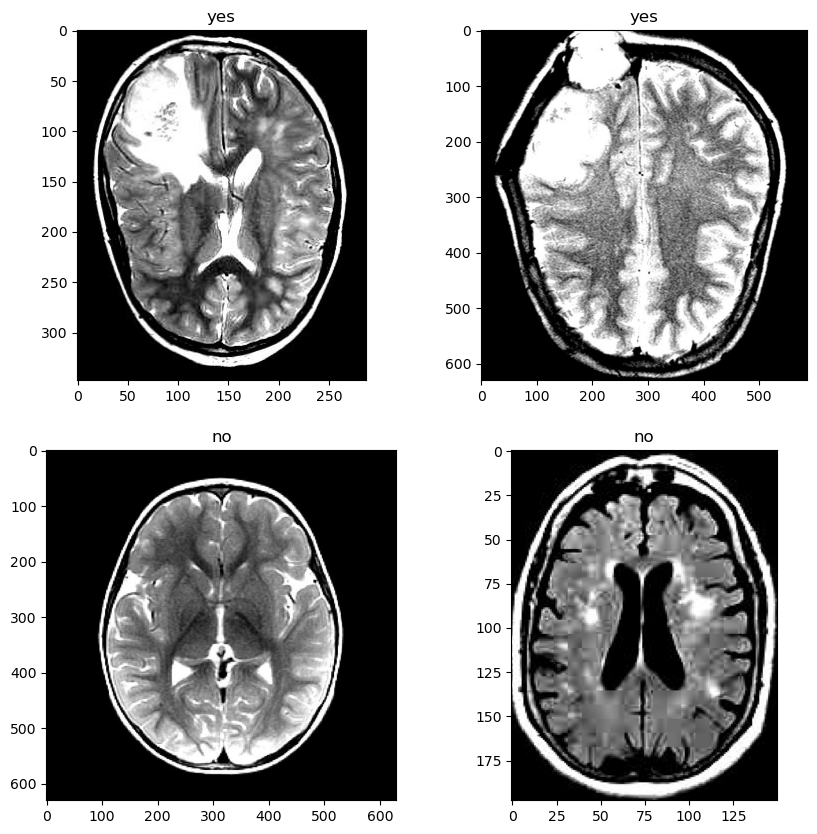

In [2]:
#Plot some MRI images
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)        # displays an image loaded from the 'yes' directory.
plt.imshow(load_img(os.path.join('yes', os.listdir('yes')[0])))
plt.title('yes')
plt.subplot(2, 2, 2)
plt.imshow(load_img(os.path.join('yes', os.listdir('yes')[1])))
plt.title('yes')

plt.subplot(2, 2, 3)
plt.imshow(load_img(os.path.join('no', os.listdir('no')[0])))
plt.title('no')
plt.subplot(2, 2, 4)         # displays another image from the 'no' directory.
plt.imshow(load_img(os.path.join('no', os.listdir('no')[1])))
plt.title('no')

In the first subplot (top left), it loads and displays an image from the 'yes' directory using the `load_img` function. It then sets the title of the subplot as 'yes'.

Overall, this code visualizes four MRI images: two labeled as 'yes' and two labeled as 'no' in separate subplots.

## Image Augmentation

As much as our training set contains more data, the model's accuracy will improve. Data augmentation is a technique used to increase the amount of data by adding slightly modified copies of already existing data.

In [3]:
#Define a function for image augmentation

def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest',
                                  rescale= 1/255
                                 )

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

The code is for performing image augmentation on a set of images. Image augmentation is a technique used to artificially increase the size of a training dataset by applying various transformations to the original images. This helps to improve the generalization and performance of machine learning models.

* applying transformations to the original images. 
* function used in `ImageDataGenerator` object to apply transformations like rotation, shift, shear, brightness, and flipping. 

In [4]:
#Create augmented images folders
#L = ['aug_train', 'aug_test', 'aug_val']
name = 'aug_data'                   # The variable name is assigned the value 'aug_data'
if not os.path.exists("./"+name): #This line checks if a folder named "aug_data" does not exist in the current directory.
  os.mkdir("./"+name)
  for dir in os.listdir(root):  # This line loops over each directory present in the "root" directory.
    os.makedirs("./"+name+"/"+dir)
else:
  print(f"{name} Already exists")

aug_data Already exists


* Overall, this code creates a folder structure for storing augmented images, with a main "aug_data" folder and subdirectories mirroring the directories in the root directory.

In [16]:
#Augment data for the examples with the label 'yes' in the training set
augment_data(file_dir=r'C:\Users\Admin\Downloads\CodeClause\Brain Taumor Detection\yes',n_generated_samples=5, save_to_dir=r'C:\Users\Admin\Downloads\CodeClause\Brain Taumor Detection\aug_data\yes')
#Augment data for the examples with the label 'no' in the training set
augment_data(file_dir=r'C:\Users\Admin\Downloads\CodeClause\Brain Taumor Detection\no', n_generated_samples=8, save_to_dir=r'C:\Users\Admin\Downloads\CodeClause\Brain Taumor Detection\aug_data\no')

The code is essentially applying image augmentation techniques to expand and diversify the training dataset for better model performance and generalization.

## **Split data into train, validation and test sets**

In [18]:
#Count images in the two folders: yes (Tumor) and no (Healthey) in the folder of augmented images
root =  r'C:\Users\Admin\Downloads\CodeClause\Brain Taumor Detection\aug_data'

# empty dictionary named dict_img is initialized.
dict_img = {}            

#line starts a loop that iterates over each directory present in the root directory.
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img 

{'no': 5083, 'yes': 3602}

It creates a dictionary, dict_img, where the keys represent the folder names and the values represent the count of images in each folder. The code uses os.listdir and len to count the number of files in each folder and stores the counts in the dictionary. Finally, it outputs the dict_img dictionary with the image counts.

In [5]:
#Define a function that creates new folders for the train, test and val sets and append random pictures to them based on the split percentage
def create_folders(name, perc):
  if not os.path.exists("./"+name):
    os.mkdir("./"+name)
    for dir in os.listdir(root):
      os.makedirs("./"+name+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(root, dir)), size=(math.floor(perc*dict_img[dir])), replace=False):
        Src = os.path.join(root, dir, img)
        Dest = os.path.join("./"+name, dir)
        shutil.copy(Src, Dest)
        os.remove(Src)
  else:
    print(f"{name} Already exists")

The code defines a function called create_folders that creates new folders for train, test, and validation sets. The function takes two parameters: name for the name of the new folder to create (e.g., train, test, val) and perc for the percentage of images to include in the new folder.

This function facilitates the creation of train, test, and validation sets by splitting and organizing images based on the specified percentage.

### Creating a Folders for [train, test, and validation]

In [20]:
#Create the training set
create_folders('train', 0.7)

In [21]:
#Create the test set
create_folders('test', 0.15)

In [22]:
#Create the validation set
create_folders('val', 0.15)

In [6]:
#Define a function that counts images in the folders: yes (Tumor) and no (Healthey)

def count_img(folder):
  dict_img = {}
  for dir in os.listdir(folder):
    dict_img[dir] = len(os.listdir(os.path.join(folder, dir)))
  return dict_img

The count_img function counts the number of images in the "yes" (Tumor) and "no" (Healthy) folders within a given directory. It returns a dictionary with the image counts for each folder.

In [7]:
#Count images in the training set
count_img('train')

{'no': 2029, 'yes': 2029}

In [8]:
#Count images in the test set
count_img('test')

{'no': 762, 'yes': 540}

In [9]:
#Count images in the validation set
count_img('val')

{'no': 762, 'yes': 540}

## **Image Preprocessing**

In [16]:
#Define a function that crop tha brain contour
def crop_brain_contour(image, plot=False):
    
    #Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    #Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    #Extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

The crop_brain_contour function is used to extract the brain contour from an input image. It applies image processing techniques like thresholding, contour detection, and extreme point calculation to locate the brain region. The function then crops the original image based on the extreme points to obtain a cropped image containing only the brain. Optionally, it can plot and display the original and cropped images. This code is helpful for tasks involving brain analysis, segmentation, or feature extraction.

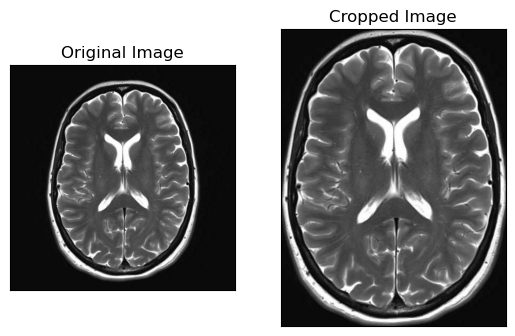

In [17]:
#Example
ex_img = cv2.imread(r'C:\Users\Admin\Downloads\CodeClause\Brain Taumor Detection\no\no39.jpg')

# this function is to extract the brain contour from an input image.
img = crop_brain_contour(ex_img, plot=True)

the crop_brain_contour function with the image as input and sets the plot parameter to True to visualize the original and cropped images.

In [18]:
#Define a function that load data
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

The load_data function loads and preprocesses images from multiple directories. It crops the brain contour, resizes the images, normalizes the pixel values, and assigns labels based on the directory name. The function returns the processed image data and labels.

Overall, the load_data function loads images, crops the brain contour, resizes and normalizes them, and prepares the input data (X) and target labels (y) for machine learning tasks.

In [19]:
#Load trainig data

# Create an array with the desired shape
array = np.zeros((200, 200, 3), dtype=np.float32)

# Change the data type to float32
#array = array.astype(np.float32)

IMG_WIDTH, IMG_HEIGHT = (200, 200)

The code creates an array with a shape of (200, 200, 3) using np.zeros. This represents an image with a width and height of 200 pixels and 3 color channels (RGB).
The data type of the array is set to np.float32 using dtype=np.float32.
The values in the array are initialized to zeros.
The variables IMG_WIDTH and IMG_HEIGHT are assigned the values 200, representing the desired width and height of the image.

In [20]:
# Load TRAIN data
IMG_WIDTH, IMG_HEIGHT = (200, 200)
X_train, y_train = load_data([r'C:\Users\Admin\Downloads\CodeClause\Brain Taumor Detection\train\yes',r'C:\Users\Admin\Downloads\CodeClause\Brain Taumor Detection\train\no'],(IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 4058
X shape is: (4058, 200, 200, 3)
y shape is: (4058, 1)


The function returns the processed training data and labels, which are assigned to the variables X_train and y_train. The X_train variable represents the training images, and y_train represents their corresponding labels.

In [21]:
#Define a function that plot images
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

The plot_sample_images function plots a sample of images with their corresponding labels.

* It takes image data (X), labels (y), and the number of images to plot (n) as inputs.
* The function loops through the labels and selects n images for each label.
* It creates a subplot grid and plots the selected images.
* The plot settings are adjusted to remove ticks and labels.
* The title of the plot indicates the corresponding label ("Yes" for Tumor or "No" for Healthy).
* The plotted images are displayed.
* This function provides a compact way to visualize a sample of images and their labels, allowing for quick insights into the data.

CODE USE FOR :
Defines a function called plot_sample_images that is used to visually examine a sample of images along with their corresponding labels. The purpose of this function is to provide a quick and convenient way to gain insights into the image data and understand the distribution of labels (Tumor or Healthy). By plotting a subset of images from each label category, it becomes easier to observe patterns, variations, or any distinguishing features that may exist between the two classes. This function can be useful during the exploratory data analysis phase or when evaluating the performance of a classification model.

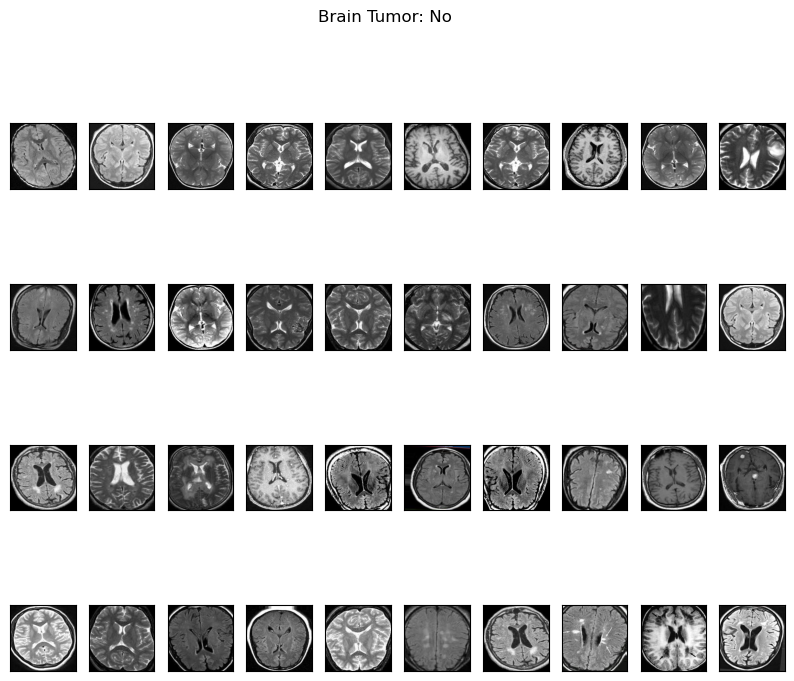

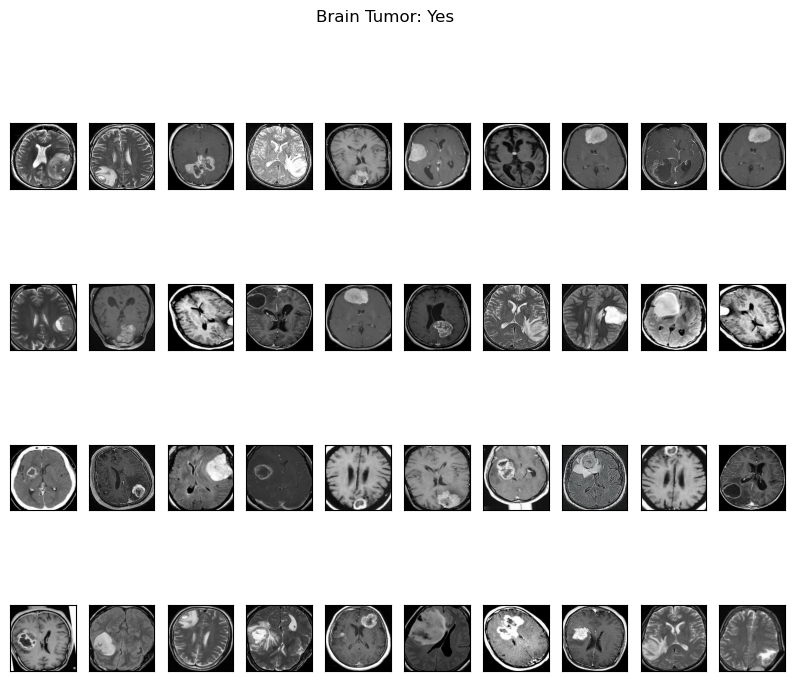

In [23]:
#Plot samples from the training set
plot_sample_images(X_train, y_train)

We can notice that the noise has been deleted and some images look alike with some slight changes resulted from the data augmentation

In [24]:
#Load test data
IMG_WIDTH, IMG_HEIGHT = (200, 200)
X_test, y_test = load_data([r'C:\Users\Admin\Downloads\CodeClause\Brain Taumor Detection\test\yes', r'C:\Users\Admin\Downloads\CodeClause\Brain Taumor Detection\test\no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1302
X shape is: (1302, 200, 200, 3)
y shape is: (1302, 1)


The function returns the processed test data and labels, which are assigned to the variables X_test and y_test. The X_test variable represents the test images, and y_test represents their corresponding labels. This allows for evaluating the performance of the model on unseen data.

In [25]:
#Load validation data
IMG_WIDTH, IMG_HEIGHT = (200, 200)
X_val, y_val = load_data([r'C:\Users\Admin\Downloads\CodeClause\Brain Taumor Detection\val\yes', r'C:\Users\Admin\Downloads\CodeClause\Brain Taumor Detection\val\no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1302
X shape is: (1302, 200, 200, 3)
y shape is: (1302, 1)


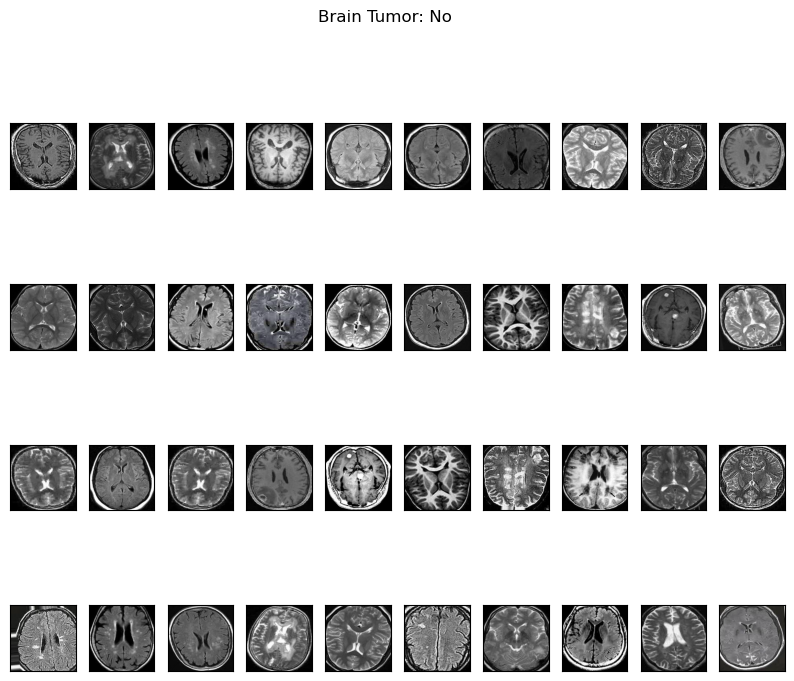

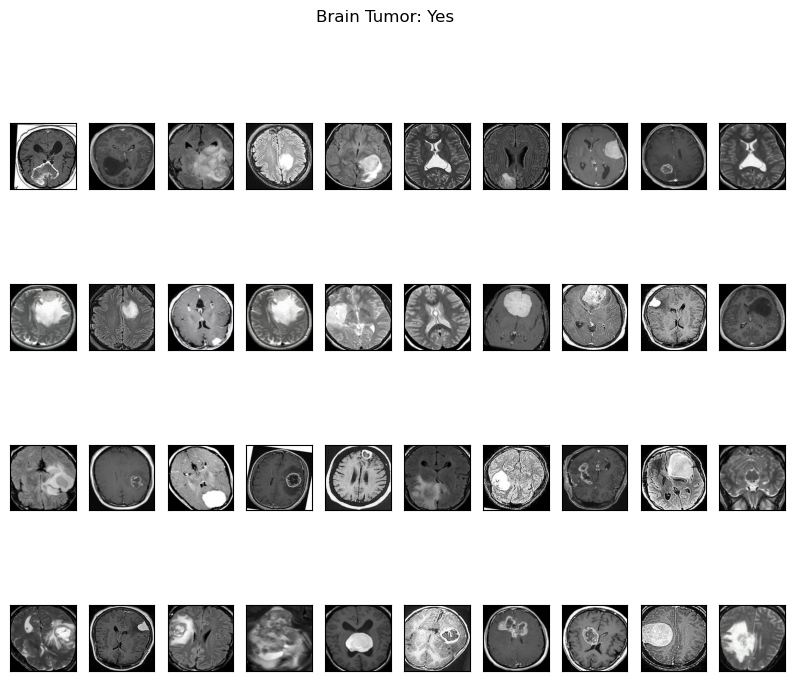

In [26]:
#Plot samples from the validation set
plot_sample_images(X_val, y_val)

the function plot_sample_images with the arguments X_val and y_val. This function is used to visually examine a sample of images along with their corresponding labels. In this case, it is plotting a sample of images from the validation set.

## **CNN Model**

In [27]:
#Build our model
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (200, 200, 3)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.25)) 
model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 196, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 46, 46, 128)       7

This code defines the architecture of a convolutional neural network (CNN) model for image classification, specifically for classifying brain tumor images into two classes: Tumor and Healthy. The model consists of convolutional layers to extract features from the images, followed by fully connected layers to classify the features and produce the final prediction.

In [28]:
#Compile our model
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [30]:
#Early stopping and model checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor ='val_accuracy', filepath = 'C:/Users/Admin/Downloads/CodeClause/Brain Taumor Detection/bestmodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cd = [es, mc]

In [31]:
#Train our model
hist = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 20, validation_data = (X_val, y_val), callbacks = cd, verbose = 1)

Epoch 1/20
127/127 [==============================] - ETA: 0s - loss: 0.6638 - accuracy: 0.5897
Epoch 1: val_accuracy improved from -inf to 0.74347, saving model to C:/Users/Admin/Downloads/CodeClause/Brain Taumor Detection\bestmodel.h5
127/127 [==============================] - 325s 3s/step - loss: 0.6638 - accuracy: 0.5897 - val_loss: 0.6071 - val_accuracy: 0.7435
Epoch 2/20
127/127 [==============================] - ETA: 0s - loss: 0.4675 - accuracy: 0.7716
Epoch 2: val_accuracy improved from 0.74347 to 0.79800, saving model to C:/Users/Admin/Downloads/CodeClause/Brain Taumor Detection\bestmodel.h5
127/127 [==============================] - 309s 2s/step - loss: 0.4675 - accuracy: 0.7716 - val_loss: 0.5745 - val_accuracy: 0.7980
Epoch 3/20
127/127 [==============================] - ETA: 0s - loss: 0.3516 - accuracy: 0.8504
Epoch 3: val_accuracy improved from 0.79800 to 0.85484, saving model to C:/Users/Admin/Downloads/CodeClause/Brain Taumor Detection\bestmodel.h5
127/127 [==========

* model.fit() is a method in Keras that trains the model on the given data.
* x=X_train and y=y_train specify the training data and labels respectively.
* batch_size=32 indicates that the training data will be divided into batches of size 32 for training.
* epochs=20 specifies the number of times the entire training dataset will be passed through the model during training.
* validation_data=(X_val, y_val) provides the validation data and labels to evaluate the model's performance during training.
* callbacks=cd refers to the list of callbacks defined earlier, cd, which includes the EarlyStopping and ModelCheckpoint callbacks.
* verbose=1 prints the progress bar and training information during the training process.


Early stopping is a technique commonly used during training to prevent overfitting and improve generalization performance.

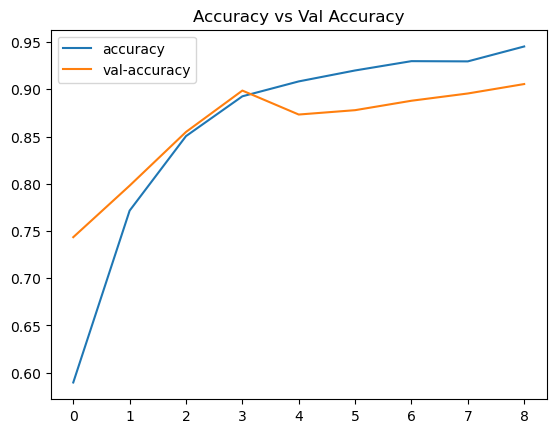

In [32]:
#Plot the graphical interpretation
h = hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

The purpose of this code is to visualize the training progress by plotting the accuracy and validation accuracy over the epochs. It helps in understanding how well the model is learning from the training data and whether it's overfitting or generalizing well to the validation data.

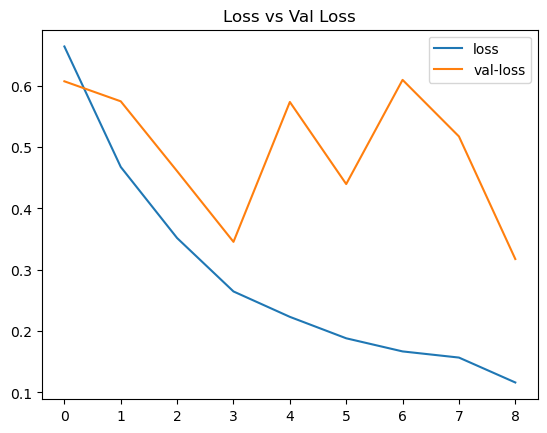

In [35]:
#Plot the graphical interpretation
h = hist.history
plt.plot(h['loss'], label = 'loss')  # The function is used to create the line plot.
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

this code generates a line plot showing the changes in loss and validation loss over the epochs, providing a visual representation of the model's performance during training.

In [36]:
#Test our model on the test set
from keras.models import load_model
model = load_model('C:/Users/Admin/Downloads/CodeClause/Brain Taumor Detection/bestmodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

41/41 [==============================] - 21s 495ms/step - loss: 0.3066 - accuracy: 0.9071
The accuracy of our model is 0.9070660471916199


Finally, the code prints the accuracy of the model using a formatted string. The value of acc is displayed within the string to provide the accuracy information.
The output you provided shows that the accuracy of the tested model is approximately 0.9071.

We can see that our model works well on the test set, so it's not overfitted

In [58]:
#Try our model on a random image that it has never seen before
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#Choose a MRI image with tumor
path = r"C:\Users\Admin\Downloads\CodeClause\Brain Taumor Detection\archive\pred\pred7.jpg"
img_yes = load_img(path, target_size=(200,200))
img_array_yes = img_to_array(img_yes)/255     # loaded image is converted to an array
img_array_yes = np.expand_dims(img_array_yes, axis=0)  #function is used to add an extra dimension to the image array.
prediction1 = model.predict(img_array_yes)
class1 = np.round(prediction1).astype(int)
if class1 == 0:
  print("The MRI image doesn't have a Tumor")
else:
  print("The MRI image has a tumor")

1/1 [==============================] - 0s 65ms/step
The MRI image has a tumor


In the given example, the output shows that the MRI image has a tumor. This indicates that the trained model predicted the presence of a tumor in the given image.

In [59]:
#Choose a MRI image without tumor
path = r"C:\Users\Admin\Downloads\CodeClause\Brain Taumor Detection\archive\pred\pred37.jpg"
img_no = load_img(path, target_size=(200,200))
img_array_no = img_to_array(img_no)/255
img_array_no = np.expand_dims(img_array_no, axis=0)
prediction2 = model.predict(img_array_no)[0][0]
class2 = np.round(prediction2).astype(int)
if class2 == 0:
  print("The MRI image doesn't have a Tumor")
else:
  print("The MRI image has a tumor")

1/1 [==============================] - 0s 69ms/step
The MRI image doesn't have a Tumor


The output you provided shows that the code printed "The MRI image doesn't have a Tumor". This indicates that the trained model predicted the absence of a tumor in the given image.

# Conclusion:

### Now, the model detects brain tumor with:
### 90.71% accuracy on the test set.
### These resutls are very good considering that the data is balanced.